In [170]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from interpolation import BarycentricInterpolation

from collocation_improved import lagrange_basis
from scipy.integrate import quad

### Simple Linear ODE

In [171]:
def f(t, u):
    return -u 

### Params and collocation points

In [172]:
T = 1.0  # end time
N = 10  # number of grid points
interpolator = BarycentricInterpolation(N, start=0, stop=T)
t_grid = interpolator.nodes

### Lagrange and Interpolation

In [173]:
def lagrange_basis(t, k, t_grid):
    terms = [(t - t_grid[m]) / (t_grid[k] - t_grid[m]) for m in range(len(t_grid)) if m != k]
    return jnp.prod(jnp.array(terms))


def interpolate(u, t, t_grid):
    """
    u: The array of function values at the grid points
    t: The point at which to interpolate
    t_grid: The array of interpolation nodes
    """
    if u.ndim == 1:
        return jnp.sum(jnp.array([u_k * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)]))
    return jnp.array([jnp.sum(jnp.array([u_k[i] * lagrange_basis(t, k, t_grid) for k, u_k in enumerate(u)])) for i in range(u.shape[1])])


### Integral Function 
* to compute the integral of $f$ from $t_k$ to $t_{k+1}$ using the trapezoid rule

In [174]:
def integral(f, t_k, t_k1, u, t_grid):
    """
    s - variable of integration
    t_k - lower bound of the integral
    t_k1 - upper bound of the integral
    u - array of function values at the grid points
    t_grid - the array of interpolation nodes
    """
    integrand = lambda s: f(s, interpolate(u, s, t_grid))
    vectorized_integrand = jax.vmap(integrand)
    s_values = jnp.linspace(t_k, t_k1, 100)
    integrand_values = vectorized_integrand(s_values)
    integral_value = jnp.trapezoid(integrand_values, s_values, axis=0)
    return integral_value


### Collocation System

In [175]:
def system(u, t_grid, f, u0):
    eqs = [u[0] - u0]
    
    for k in range(1, len(t_grid)):
        eq = u[k] - u[k-1] - integral(f, t_grid[k-1], t_grid[k], u, t_grid)
        eqs.append(eq)
    
    return jnp.array(eqs)

The Newton-Raphson method for solving a system of nonlinear equations involves iteratively solving the linear system:

$$
\mathbf{J}(u) \Delta u = -\mathbf{F}(u)
$$

for the correction term $\Delta u$, where $\mathbf{J}(u)$ is the Jacobian matrix of the system of equations $\mathbf{F}(u)$ at the current approximation $u$.


$\mathbf{J}(u) \Delta u = -\mathbf{F}(u)$

In [176]:
def newton_method(u_init, t_grid, f, u0 = 1, tol=1e-6, max_iter=100):
    u = u_init
    for i in range(max_iter):
        F_u = system(u, t_grid, f, u0)
        
        # Compute the Jacobian of the system
        J_u = jacfwd(system)(u, t_grid, f, u0)
        
        # Flatten the Jacobian and F_u for solving
        F_u_flat = F_u.reshape(-1)
        J_u_flat = J_u.reshape(F_u_flat.shape[0], -1)
        
        # Solve for the update Δu in the linear system J(u) Δu = -F(u)
        delta_u_flat = jnp.linalg.solve(J_u_flat, -F_u_flat)
        
        # Reshape the update and apply
        delta_u = delta_u_flat.reshape(u.shape)
        u = u + delta_u
        
        norm_delta_u = jnp.linalg.norm(delta_u)
        if norm_delta_u < tol:
            print(f"Converged at iteration {i+1}")
            return u
    
    raise ValueError("Newton's method did not converge")

In [177]:
# Initial guess
u_init = jnp.ones((N,))  # Start with a non-zero initial guess

# Solve the system
u_solution = newton_method(u_init, t_grid, f)

# Print the solution
print("Solution at grid points:", u_solution)


Converged at iteration 2
Solution at grid points: [1.         0.9702964  0.88960496 0.77880076 0.66154586 0.55609052
 0.47236648 0.41353117 0.37914124 0.36787938]


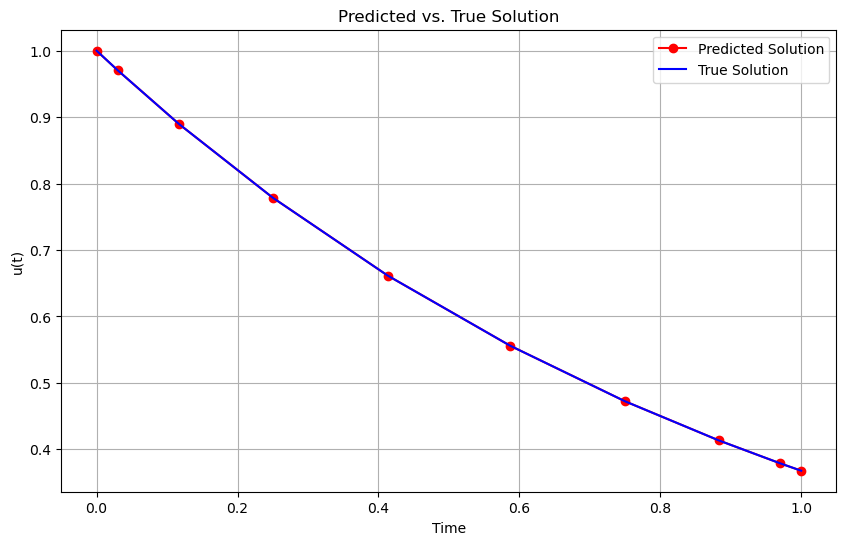

In [178]:
# True solution for comparison
u0 = 1.0  # initial condition
true_solution = u0 * jnp.exp(-t_grid)

# Plot predicted vs. true solution
plt.figure(figsize=(10, 6))
plt.plot(t_grid, u_solution, 'ro-', label='Predicted Solution')
plt.plot(t_grid, true_solution, 'b-', label='True Solution')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted vs. True Solution')
plt.grid(True)
plt.show()

In [166]:
uv_init

Array([[1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float64)

In [181]:
omega = 1.0  # Frequency of the harmonic oscillator

def f_2(t, uv):
    # print(type(uv))
    u, v = uv
    return jnp.array([v, -omega**2 * u])

# Parameters
T = 4.0  # End time
N = 20  # Number of grid points

# Create the grid points
t_grid = jnp.linspace(0, T, N)

# Initial guess for the solution
uv_init = jnp.ones((N, 2))  # Start with a non-zero initial guess
uv_init = uv_init.at[0, 1].set(0)  # Set the initial velocity to 0

u0=jnp.array([1.0, 0.0])

# Solve the system
uv_solution = newton_method(uv_init, t_grid, f_2, u0)

print("Solution at grid points:", uv_solution)


Converged at iteration 2
Solution at grid points: [[ 1.          0.        ]
 [ 0.97792108 -0.20897455]
 [ 0.91265928 -0.40872123]
 [ 0.80709641 -0.59041966]
 [ 0.66589391 -0.74604644]
 [ 0.49528698 -0.86872942]
 [ 0.30280924 -0.95305119]
 [ 0.0969601  -0.99528827]
 [-0.11317059 -0.99357557]
 [-0.31830391 -0.94798872]
 [-0.50938162 -0.86054074]
 [-0.67796613 -0.73509314]
 [-0.81661313 -0.57718541]
 [-0.91920025 -0.39379042]
 [-0.98119748 -0.1930065 ]
 [-0.99986714  0.01630017]
 [-0.97438484  0.22488706]
 [-0.9058758   0.42354343]
 [-0.79736524  0.60349703]
 [-0.65364476  0.75680151]]


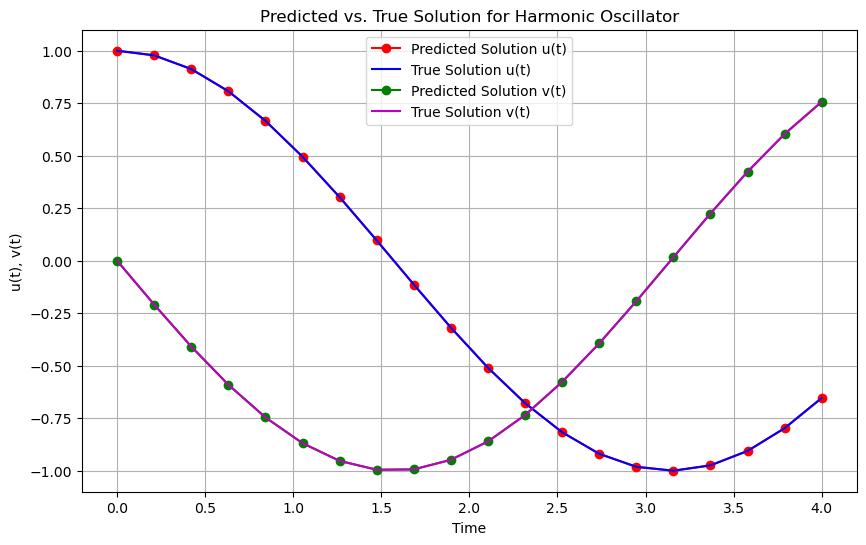

In [182]:
true_solution_u = jnp.cos(omega * t_grid)
true_solution_v = -omega * jnp.sin(omega * t_grid)

# Plot predicted vs. true solution
plt.figure(figsize=(10, 6))
plt.plot(t_grid, uv_solution[:, 0], 'ro-', label='Predicted Solution u(t)')
plt.plot(t_grid, true_solution_u, 'b-', label='True Solution u(t)')
plt.plot(t_grid, uv_solution[:, 1], 'go-', label='Predicted Solution v(t)')
plt.plot(t_grid, true_solution_v, 'm-', label='True Solution v(t)')
plt.xlabel('Time')
plt.ylabel('u(t), v(t)')
plt.legend()
plt.title('Predicted vs. True Solution for Harmonic Oscillator')
plt.grid(True)
plt.show()